# 2022机器学习期末大作业
# 题目：基于VAE的手写数字生成


成员：

于文明2011762

刘沿辰2012543

林雨豪2012516

## 实验要求：

### 基本要求：
利用 pytorch (推荐) 或 tensorflow 等神经网络框架编程实现一个变分自编码器 (Variational Auto Encoder, VAE)；分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数生成新的手写数字,分析结果并展示生成的手写数字；
### 中级要求：
实现VAE的变分推断(最好是手写推导)，描述VAE的由来以及优缺点；
### 提高要求：
实现任意形式的对VAE进行改进或创新，例如：和其他网络结合或对比（图卷积神经网络(GCN)，生成对抗网络(GAN)，Diffusion Model等）；实现VAE的变种（β-VAE，β-TCVAE等）；修改数据集（例如加噪点，加mask等）以发掘VAE更多的功能；对可视化方法进行创新（例如输出隐变量）……

## 成员分工：

### 于文明：
完成初级要求网络搭建、高级要求GAN部分实现

### 刘沿辰：
完成中级要求变参推导、VAE网络结构优化与调参

### 林雨豪：
完成高级要求β-VAE部分实现、材料整理与结果分析

### 一、基本要求：基于pytorch实现VAE，生成手写数字

In [1]:
# 需提前安装Pytorch和对应版本的torchvision
import os
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 下载MNIST数据集
dataset = MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
batch_sz = 128   # 数据集切分，每个batch大小为128
dataIter = Data.DataLoader(dataset, batch_size=batch_sz, shuffle=True)

In [4]:
# 查看张量的维度数：N(num),C(channel),H(height),W(width)
x, y = next(iter(dataIter))
x.shape  # torch.Size([128, 1, 28, 28]), 表示每个batch有128张图，只有一个channel(黑白)，长宽分别是28*28

torch.Size([128, 1, 28, 28])

In [5]:
# 展平
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)   # torch.Size([128, 784])

In [6]:
# 建立VAE模型，encoder与decoder新增3个维度为400的隐藏层
class VAE(nn.Module):
    def __init__(self, count_size = 784, h_dim_0=400, h_dim=256, z_dim=20):
        # 输入维度是784，中间Encoder、Decoder的维度是256，隐变量维度是20
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(count_size, h_dim_0)  # Encoder
        self.fc2 = nn.Linear(h_dim_0, h_dim_0)  # Encoder 隐藏层1
        self.fc2_1 = nn.Linear(h_dim_0, h_dim_0)  # Encoder 隐藏层2
        self.fc2_2 = nn.Linear(h_dim_0, h_dim)  # Encoder 隐藏层3
        self.fc3 = nn.Linear(h_dim, z_dim)  # 均值 向量
        self.fc4 = nn.Linear(h_dim, z_dim)  # 方差 向量
        self.fc5 = nn.Linear(z_dim, h_dim)  # Decoder
        self.fc6 = nn.Linear(h_dim, h_dim_0)  # Decoder 隐藏层1
        self.fc6_1 = nn.Linear(h_dim_0, h_dim_0)  # Decoder 隐藏层2
        self.fc6_2 = nn.Linear(h_dim_0, h_dim_0)  # Decoder 隐藏层3
        self.fc7 = nn.Linear(h_dim_0, count_size)  # output


    # 编码
    def encode(self, x):
        h_0 = F.relu(self.fc1(x))
        h_1 = F.relu(self.fc2(h_0))
        h_2 = F.relu(self.fc2_1(h_1))
        h = F.relu(self.fc2_2(h_2))
        return self.fc3(h),self.fc4(h)

    # 重参数化生成隐变量
    def reparameterize(self, mu, log_var):
        std=torch.exp(log_var/2)
        eps=torch.randn_like(std)
        return mu+eps*std

    # 解码
    def decode(self, z):
        h_0 = F.relu(self.fc5(z))
        h_1 = F.relu(self.fc6(h_0))
        h_2 = F.relu(self.fc6_1(h_1))
        h=F.relu(self.fc6_2(h_2))
        return F.sigmoid(self.fc7(h))

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        mu,log_var=self.encode(x)
        z=self.reparameterize(mu,log_var)
        x_reconst=self.decode(z)
        return x_reconst,mu,log_var

In [12]:
# 训练模型
def training(loss_func):
    image_size=784
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备
    learning_rate = 1e-3  # 学习率
    epoches = 20  # 迭代20次
    
    # 实例化一个模型
    model = VAE().to(device)

    # 创建优化器
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 训练
    train_loss = [0.] * epoches  # 保存每个epoch的训练误差
    for epoch in range(epoches):
        for i, (x, y) in enumerate(dataIter):
            # 展平并训练
            # 计算损失函数
            # 反向传播和优化
            x=x.to(device).view(-1,image_size)
            x_reconst,mu,log_var=model(x)
            if loss_func == "mse_loss":
                reconst_loss = F.mse_loss(x_reconst,x,size_average=False)
            elif loss_func == "binary_cross_entropy":
                reconst_loss = F.binary_cross_entropy(x_reconst,x,size_average=False)
            else:
                reconst_loss = F.binary_cross_entropy(x_reconst,x,size_average=False)
            kl_div=-0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())
            loss=reconst_loss+kl_div
            train_loss[epoch] = train_loss[epoch] + loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            pass
            # 输出batch信息
            if i % 200 == 0 and i > 0:
                print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch + 1, i, loss.cpu().item()/len(x)))

        # 输出epoch信息
        print("epoch[{}/{}] | loss:{}"
                      .format(epoch + 1, epoches, train_loss[epoch] / len(dataIter.dataset)))
        # 每学习七轮就降低学习率
        if(epoch % 7 == 6):
            learning_rate = learning_rate * 0.5;
    
    #--------------------cpu版查看图片--------------------#
    z = torch.randn((batch_sz, 20)).to(device)
    logits = model.decode(z)  # 仅通过解码器生成图片
    x_hat = torch.sigmoid(logits)  # 转换为像素范围
    x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
    # 展示图片
    _ ,axes = plt.subplots(6, 6)
    for i in range(6):
        for j in range(6):
            axes[i][j].axis('off')
            axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
    plt.show()
    #--------------------cpu版查看图片--------------------#
    
    """
    #--------------------gpu版查看图片--------------------#
    # evaluation 测试生成效果，从正态分布随机采样z
    z = torch.randn((batch_sz, 20))
    logits = model.decode(z)  # 仅通过解码器生成图片
    x_hat = torch.sigmoid(logits)  # 转换为像素范围
    x_hat = x_hat.view(128, 28, 28).detach().numpy()*255.
    # 展示图片
    _ ,axes = plt.subplots(6, 6)
    for i in range(6):
        for j in range(6):
            axes[i][j].axis('off')
            axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
    plt.show()
    #--------------------gpu版查看图片--------------------#
    """

分别使用MSE和交叉熵构建损失函数，生成的手写数字结果如下：

epoch : 1 | #batch : 200 | batch average loss: 50.788230895996094
epoch : 1 | #batch : 400 | batch average loss: 46.968406677246094
epoch[1/20] | loss:52.04907989501953
epoch : 2 | #batch : 200 | batch average loss: 42.77915954589844
epoch : 2 | #batch : 400 | batch average loss: 42.12004089355469
epoch[2/20] | loss:44.49406814575195
epoch : 3 | #batch : 200 | batch average loss: 39.805912017822266
epoch : 3 | #batch : 400 | batch average loss: 39.273406982421875
epoch[3/20] | loss:40.385169982910156
epoch : 4 | #batch : 200 | batch average loss: 39.758766174316406
epoch : 4 | #batch : 400 | batch average loss: 39.763736724853516
epoch[4/20] | loss:38.662193298339844
epoch : 5 | #batch : 200 | batch average loss: 37.86891555786133
epoch : 5 | #batch : 400 | batch average loss: 39.373600006103516
epoch[5/20] | loss:37.90716552734375
epoch : 6 | #batch : 200 | batch average loss: 37.885459899902344
epoch : 6 | #batch : 400 | batch average loss: 38.797298431396484
epoch[6/20] | loss:37.23

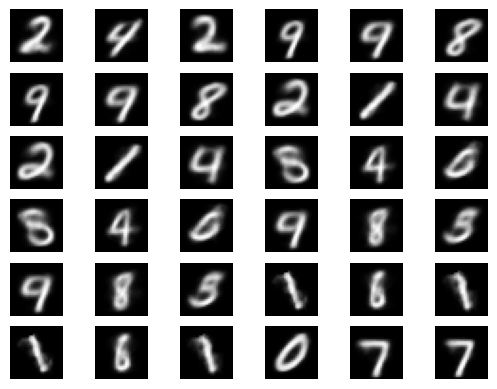

In [13]:
training("mse_loss")

epoch : 1 | #batch : 200 | batch average loss: 199.61740112304688
epoch : 1 | #batch : 400 | batch average loss: 186.0788116455078
epoch[1/20] | loss:197.5653533935547
epoch : 2 | #batch : 200 | batch average loss: 160.89231872558594
epoch : 2 | #batch : 400 | batch average loss: 161.83840942382812
epoch[2/20] | loss:165.31741333007812
epoch : 3 | #batch : 200 | batch average loss: 151.42637634277344
epoch : 3 | #batch : 400 | batch average loss: 145.1497802734375
epoch[3/20] | loss:149.81153869628906
epoch : 4 | #batch : 200 | batch average loss: 141.116943359375
epoch : 4 | #batch : 400 | batch average loss: 133.10581970214844
epoch[4/20] | loss:141.7875213623047
epoch : 5 | #batch : 200 | batch average loss: 138.45794677734375
epoch : 5 | #batch : 400 | batch average loss: 139.10189819335938
epoch[5/20] | loss:138.07102966308594
epoch : 6 | #batch : 200 | batch average loss: 141.3902587890625
epoch : 6 | #batch : 400 | batch average loss: 140.01634216308594
epoch[6/20] | loss:136.00

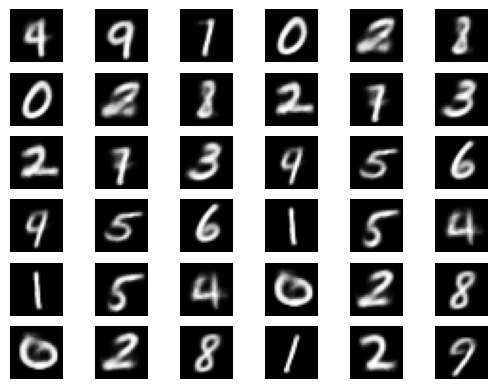

In [14]:
training("binary_cross_entropy")

### 中级要求：

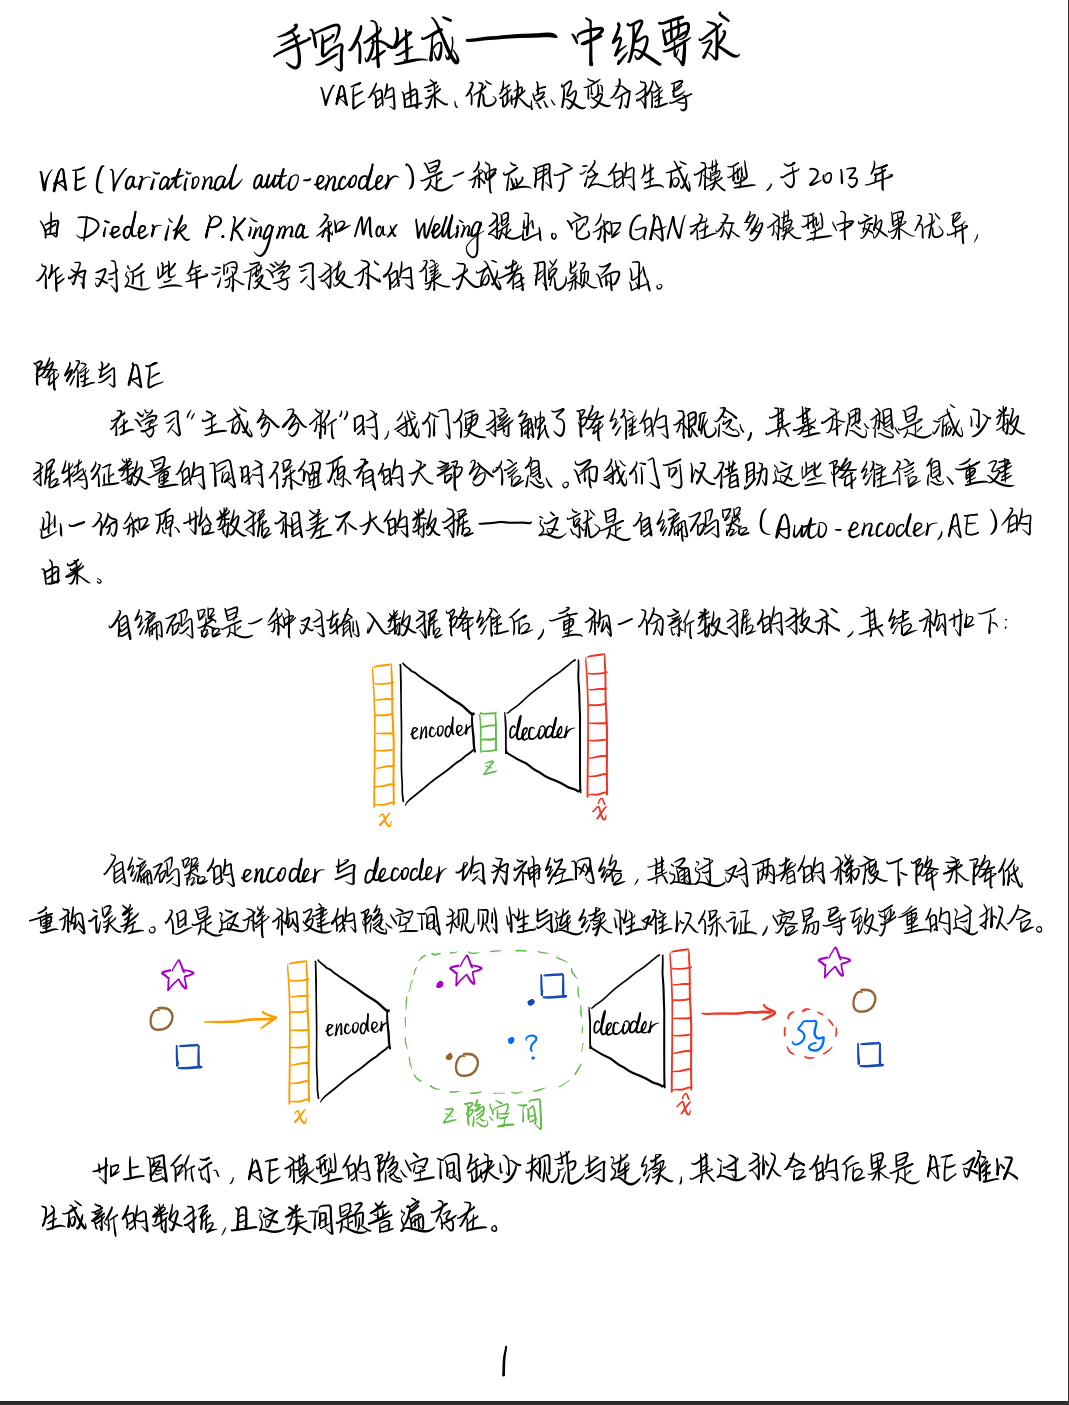

In [10]:
from IPython.display import Image
Image(filename="./推导1.png",width=900,height=1000)

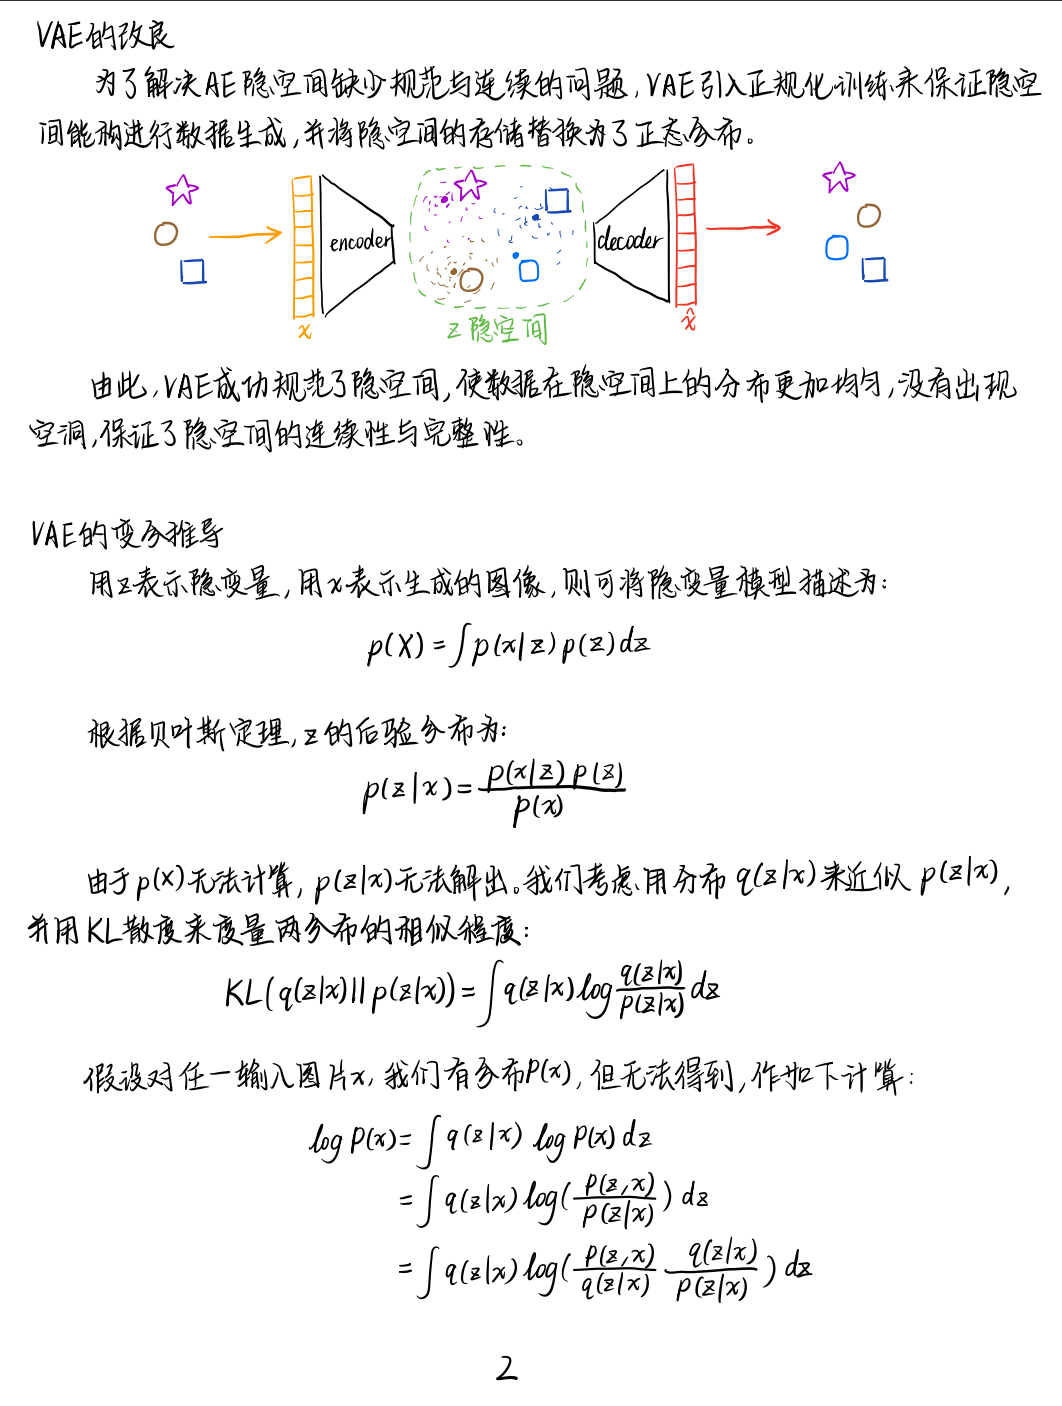

In [11]:
Image(filename="./推导2.png",width=900,height=1000)

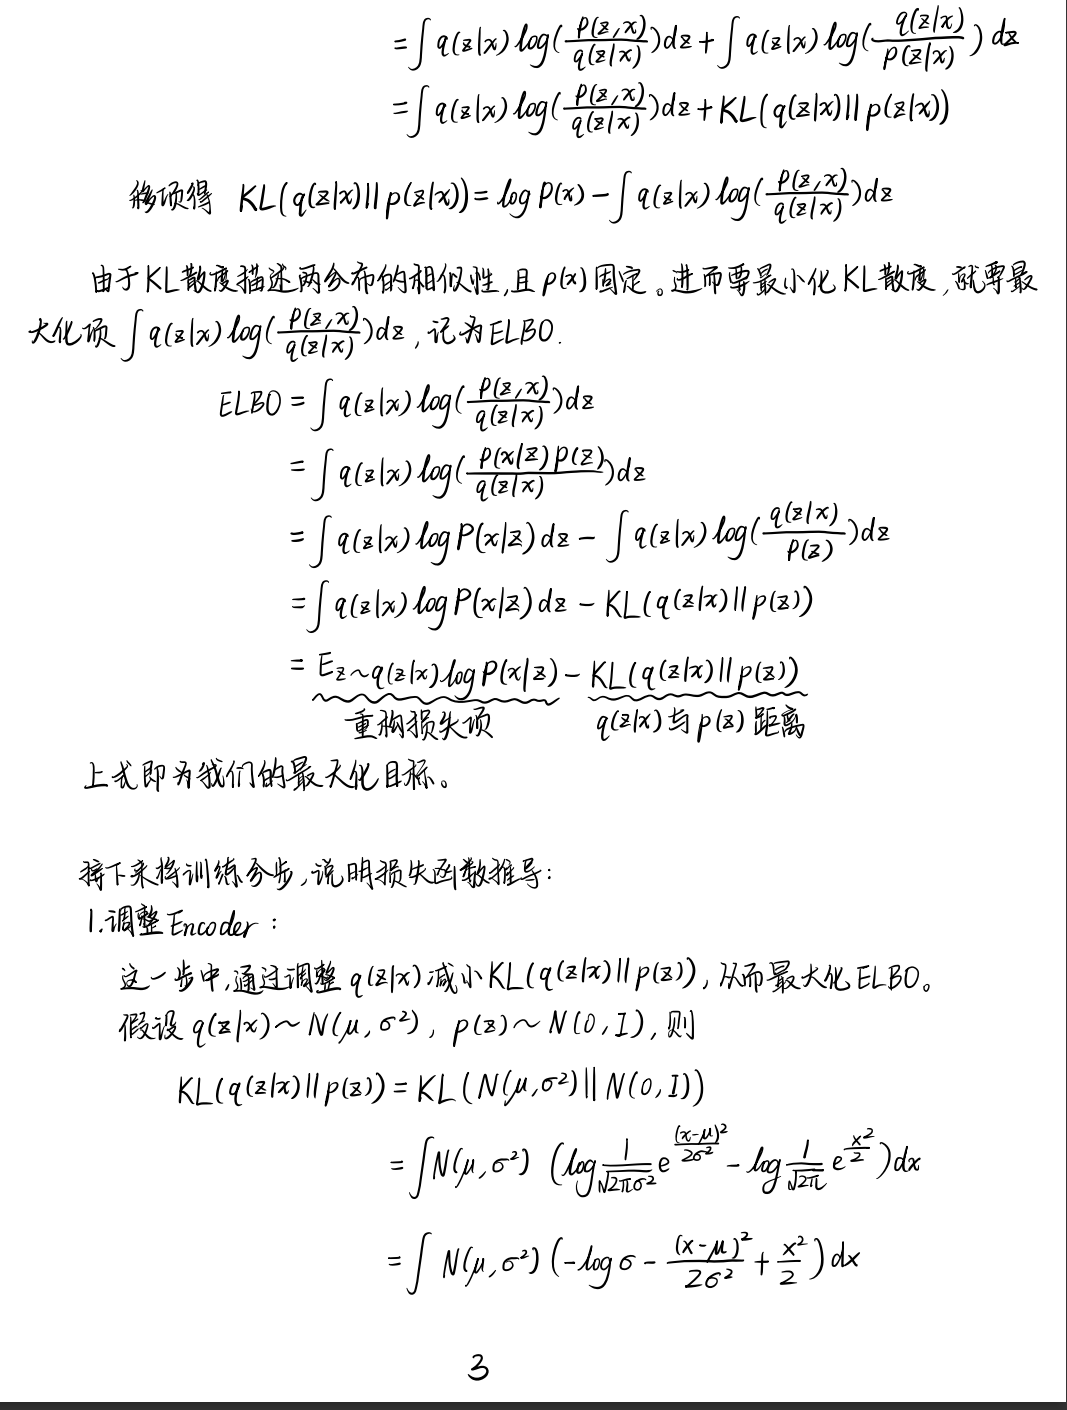

In [12]:
Image(filename="./推导3.png",width=900,height=1000)

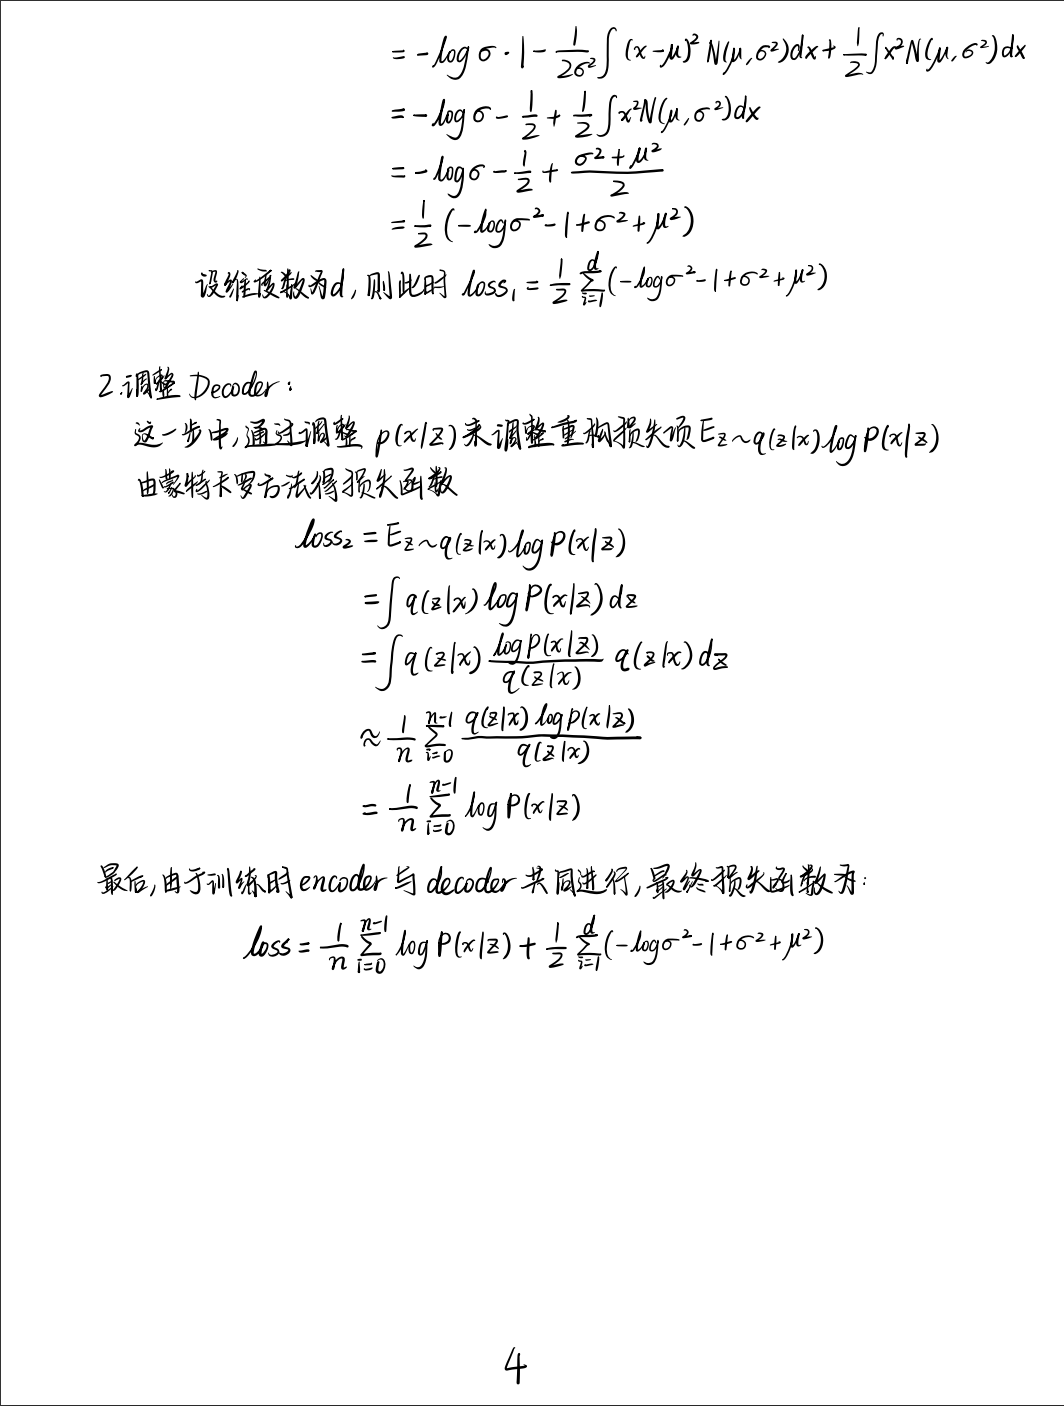

In [13]:
Image(filename="./推导4.png",width=900,height=1000)

### 提高要求

1. 实现VAE的变种（β-VAE），观察结果

VAE 和普通的自编码器之间的最大差别在于隐变量具有先验。VAE 需要最小化，因此限制了z的空间。同时，VAE 也需要在模型中最大化训练数据 x 的对数似然。在这两个目标的作用下，VAE 通过学习使 z 称为 x 的最高效的表征，即 z 被解耦到不同的维度上。VAE 的简单变体 β-VAE 为 KL 损失引入了一个大于 1 的放缩因子，从而提升解耦的重要性。

我们希望最大化生成真实数据的概率值和最小化真实和估计后验分布的KL散度,loss函数: ![loss.png](./loss.png)
标准的VAE即为β为1的情况。β>1时，前变量空间z表示信息的丰富度降低，但同时模型的解纠缠能力增加。

In [17]:
def Beta_Training(Beta = 1.0):
    # 训练模型
    image_size=784
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备
    learning_rate = 10e-3
    epoches = 20
    Beta_model = VAE().to(device)
    opt = torch.optim.Adam(Beta_model.parameters(), lr=learning_rate)
    train_loss = [0.] * epoches  # 保存每个epoch的训练误差
    for epoch in range(epoches):
        for i, (x, y) in enumerate(dataIter):
            x=x.to(device).view(-1,image_size)
            x_reconst,mu,log_var=Beta_model(x)
            # 计算损失函数
            #reconst_loss=F.binary_cross_entropy(x_reconst,x,size_average=False)
            reconst_loss=F.mse_loss(x_reconst,x,size_average=False)
            kl_div=-0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())
            # 反向传播和优化
            loss=reconst_loss+Beta*kl_div
            train_loss[epoch] = loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            pass
            if i % 200 == 0 and i > 0:
                print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.cpu().item()/len(x)))

        # 输出epoch信息
        print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch] / len(dataIter.dataset)))
    # evaluation 测试生成效果，从正态分布随机采样z
    return Beta_model

In [ ]:
model1 =  Beta_Training(Beta = 1.0)

In [ ]:
model2 =  Beta_Training(Beta = 1.2)

In [ ]:
model3 =  Beta_Training(Beta = 1.5)

In [ ]:
model4 =  Beta_Training(Beta = 1.7)

In [ ]:
model5 =  Beta_Training(Beta = 2.0)

In [ ]:
model6 =  Beta_Training(Beta = 2.5)

In [ ]:
model7 =  Beta_Training(Beta = 3.0)

In [ ]:
model8 =  Beta_Training(Beta = 3.5)

In [ ]:
model9 =  Beta_Training(Beta = 4.0)

In [ ]:
model10 =  Beta_Training(Beta = 5.0)

In [ ]:
model11 =  Beta_Training(Beta = 10.0)

以下每一行分别为是Beta取值为1.0、1.2、1.5、1.7、2.0、2.5、3.0、3.5、4.0、5.0、10.0的情况

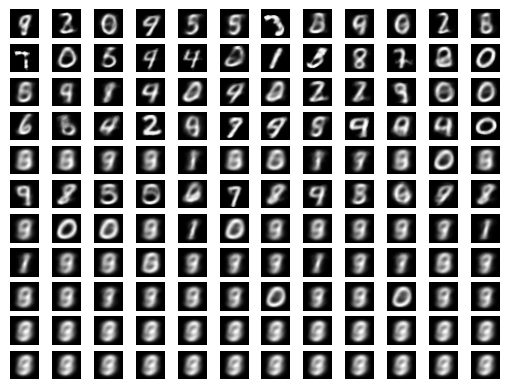

In [54]:
models =[model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11]
# evaluation 测试生成效果，从正态分布随机采样z
_ ,axes = plt.subplots(11, 12)
for i in range(11):
    z = torch.randn((batch_sz, 20))
    logits = models[i].decode(z)  # 仅通过解码器生成图片
    x_hat = torch.sigmoid(logits)  # 转换为像素范围
    x_hat = x_hat.view(128, 28, 28).detach().numpy()*255.
    # 展示图片
    for j in range(12):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

2. 基于GAN生成手写数字

GAN-生成对抗网络，两个网络分别为生成数据的生成器和鉴别生成数据的鉴别器

GAN的训练大致分为以下3部分：

1.用真实的训练数据训练鉴别器；

2.用生成的数据训练鉴别器；

3.训练生成器生成数据，使鉴别器认为其为真实数据

In [1]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms


In [3]:

# 数据归一化(-1,1)
transform = transforms.Compose([
    transforms.ToTensor(),  # 0-1
    transforms.Normalize(0.5, 0.5)  # 均值0.5方差0.5
])
# 加载内置数据集
train_ds = torchvision.datasets.MNIST('data',
                                      train=True,
                                      transform=transform,
                                      download=True)

dataloader = torch.utils.data.DataLoader(train_ds,
                                         batch_size=64,
                                         shuffle=True)




NameError: name 'torch' is not defined

In [ ]:
# 定义生成器，依然输入长度100的噪声
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(100, 256*7*7)
        self.bn1 = nn.BatchNorm1d(256*7*7)
        self.deconv1 = nn.ConvTranspose2d(256, 128,
                                          kernel_size=(3, 3),
                                          stride=1,
                                          padding=1
                                          )
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64,
                                          kernel_size=(4, 4),
                                          stride=2,
                                          padding=1
                                          )
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 1,
                                          kernel_size=(4, 4),
                                          stride=2,
                                          padding=1
                                          )

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.bn1(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.deconv1(x))
        x = self.bn2(x)
        x = F.relu(self.deconv2(x))
        x = self.bn3(x)
        x = torch.tanh(self.deconv3(x))
        return x


# 判别器,输入（28，28）图片

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 3, 2)
        self.bn = nn.BatchNorm2d(128)
        self.fc = nn.Linear(128*6*6, 1)

    def forward(self, x):
        x = F.dropout2d(F.leaky_relu(self.conv1(x)), p=0.3)
        x = F.dropout2d(F.leaky_relu(self.conv2(x)), p=0.3)
        x = self.bn(x)
        x = x.view(-1, 128*6*6)
        x = torch.sigmoid(self.fc(x))
        return x


Gen = Generator().to(device)
Dis = Discriminator().to(device)

loss_fun = nn.BCELoss()
d_optimizer = torch.optim.Adam(Dis.parameters(), lr=1e-5)  # 小技巧
g_optimizer = torch.optim.Adam(Gen.parameters(), lr=1e-4)


def generate_and_save_image(model, test_input):
    predictions = np.squeeze(model(test_input).cpu().numpy())
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1) / 2, cmap='gray')
        plt.axis('off')
    plt.show()

test_input = torch.randn(16, 100, device=device)
D_loss = []
G_loss = []


In [ ]:

for epoch in range(30):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader.dataset)
    for step, (img, _) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)
        random_noise = torch.randn(size, 100, device=device)

        d_optimizer.zero_grad()
        real_output = Dis(img)  # 判别器输入真实图片
        # 判别器在真实图像上的损失
        d_real_loss = loss_fun(real_output,
                                    torch.ones_like(real_output)
                                    )
        d_real_loss.backward()

        gen_img = Gen(random_noise)
        fake_output = Dis(gen_img.detach())  # 判别器输入生成图片,fake_output对生成图片的预测
        # gen_img是由生成器得来的，但我们现在只对判别器更新，所以要截断对Gen的更新
        # detach()得到了没有梯度的tensor，求导到这里就停止了，backward的时候就不会求导到Gen了

        d_fake_loss = loss_fun(fake_output,
                                    torch.zeros_like(fake_output)
                                    )
        d_fake_loss.backward()
        d_loss = d_real_loss + d_fake_loss
        d_optimizer.step()

        # 更新生成器
        g_optimizer.zero_grad()
        fake_output = Dis(gen_img)
        g_loss = loss_fun(fake_output,
                               torch.ones_like(fake_output))
        g_loss.backward()
        g_optimizer.step()

        with torch.no_grad():
            d_epoch_loss += d_loss.item()
            g_epoch_loss += g_loss.item()

    with torch.no_grad():  # 之后的内容不进行梯度的计算（图的构建）
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print('Epoch:', epoch+1)
        generate_and_save_image(model=Gen, test_input=test_input)

    plt.plot(D_loss, label='D_loss')
    plt.plot(G_loss, label='G_loss')
    plt.legend()
    plt.show()
